# Homework 2 Report
# Yuxin Sun
------
## 2 Understanding Data Normalization
Because `images.max()` has high probablity to return `255` if the tensor is large enough, and `tvt.toTensor` directly use `type_max(Int8)` which is `255`.

## 3.1 Setting Up Your Conda Environment
See `environment.yml`.
I use AMD GPU, so I will use DirectML for GPU calculation on wsl2:
`torch-directml==0.1.13.1.dev230119`,
`torchvision==0.14.1+rocm5.2`

## 3.2 Becoming Familiar with `torchvision.transforms`

I took two pictures of photograph of a stop sign, 
the front-view:

<img src="stop_sign_1.jpg" style="width:40%;">

and the oblique-view:

<img src="stop_sign_2.jpg" style="width:40%;">


### Crop and adjust images
**(figure numbers are in the code blocks right above those figures)**

first:

JPEG (4000, 3000) RGB
croped: None (256, 200) RGB


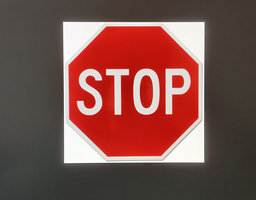

In [3]:
import torch
import torchvision.transforms as tvt
from PIL import Image

im = Image.open("stop_sign_1.jpg")
print(im.format, im.size, im.mode)
width, height = im.size
w = width/5*1.2
h = height/4*0.8
im1 = im.crop((w, h, w+2048, h+1600)).resize((256,200),resample=Image.Resampling.LANCZOS)
print("croped:", im1.format, im1.size, im1.mode)
im1 # figure 3

second:

croped: None (256, 200) RGB


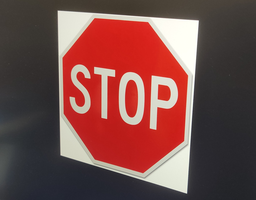

In [4]:
im = Image.open("stop_sign_2.jpg")
width, height = im.size
w = width/5*0.8
h = height/4*0.93
im2 = im.crop((w, h, w+2048, h+1600)).resize((256,200),resample=Image.Resampling.LANCZOS)
print("croped:", im2.format, im2.size, im2.mode)
im2 # figure 4

<br/>

### Try random affine

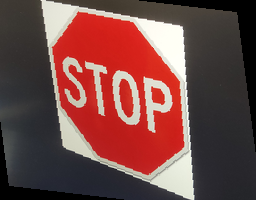

In [5]:
w, h = im1.size
im = [im1, im2]
tvt.RandomAffine([-5,5], shear=[-10,10,-5,5], translate=(0.02,0.01))(im[1])
# figure 5

I will try to optimize affine method after trying `perspective()` later.
### Use `tvt.functional.perspective`
Before using the perspective function, I approximately locate the four corners .
This is not a good way, so I will improve it later.

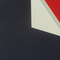

In [422]:
# end points
# a, b = 61, 22
# im[0].crop((a-30, b-30, a+30, b+30))
# a, b = 204, 22
# im[0].crop((a-30, b-30, a+30, b+30))
# a, b = 204, 165
# im[0].crop((a-30, b-30, a+30, b+30))
# a, b = 63, 165
# im[0].crop((a-30, b-30, a+30, b+30))

# starting points
# a, b = 56, 10
# im[1].crop((a-30, b-30, a+30, b+30))
# a, b = 198, 20
# im[1].crop((a-30, b-30, a+30, b+30))
# a, b = 186, 196
# im[1].crop((a-30, b-30, a+30, b+30))
a, b = 59, 158
im[1].crop((a-30, b-30, a+30, b+30))

# figure 6

Now we have all eight corner points.

Apply `tvt.functional.perspective` by using above coordinates

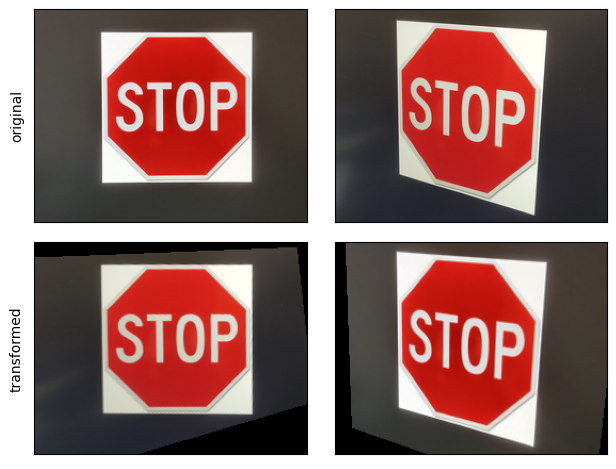

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# a plot function for convenience
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if isinstance(img, Image.Image):
                ax.imshow(img, **imshow_kwargs)
            else:
                ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

im_trans = tvt.functional.perspective(im[1],[[56, 10],[198, 20],[186, 196],[59, 158]],[[61, 22],[204, 22],[204, 165],[63, 165]])
im_trans = [im_trans, 
        tvt.functional.perspective(im[0],[[61, 22],[204, 22],[204, 165],[63, 165]],[[56, 10],[198, 20],[186, 196],[59, 158]])
]
plot([list(im),im_trans], row_title=["original", "transformed"])
# figure 7

### Calculating the distance between two images 
I cut off the green/blue channels and calculate the 2-norm as the distance.

For example, elements less that 0.5 in blue channels are set to zero, and then I subtract blue channels of two images and get its `norm()` as the distance. I think this way is more efficient than using histogram, and it is robust for small background noise. 

Now `channel_b*` has `1.0` in red regions and `0.0` in other regions.

In [7]:
xform = tvt.Compose([ tvt.ToTensor() ])
w, h = im[0].size
images = torch.zeros((2, 3, h, w), dtype=torch.float64)
images[0] = xform(im[0])
images[1] = xform(im_trans[0])

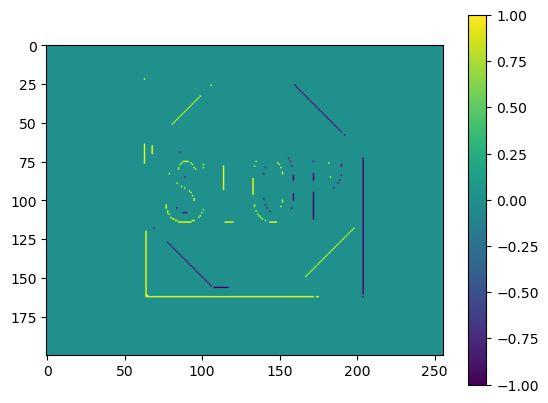

In [8]:
channel_b1 = (images[0][2]>=0.5).float()
channel_b2 = (images[1][2]>=0.5).float()
plt.imshow((channel_b1-channel_b2))
plt.colorbar()
plt.show()
# figure 8

#### distance: 2-norm of the above image
or 1-norm: counting different pixels

In [9]:
distance = (channel_b1-channel_b2).norm(2)
distance

tensor(23.4307)

### generate random parameters and apply `perspective()`
There is a stochastic non-gradient descent

start at d =  100.14988708496094
end with d =  21.0
best c1 = Corners(tl=[61, 22], tr=[204, 21], br=[203, 164], bl=[62, 167])


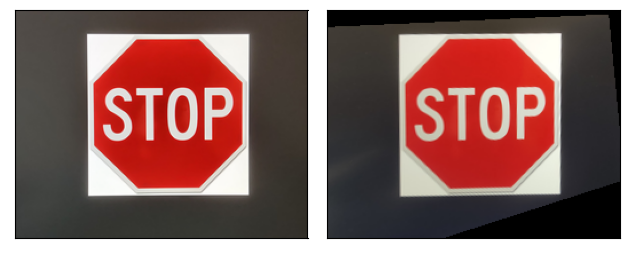

In [11]:
from typing import NamedTuple
import random

class Corners(NamedTuple):
    tl: list
    tr: list
    br: list
    bl: list

    def getvals(self):
        return [self.tl, self.tr, self.br, self.bl]

    def __call__(self):
        return [self.tl, self.tr, self.br, self.bl]

    def nextval(self):
        return [[self.getvals()[i][j]+random.randint(-2,2) for j in range(2)] for i in range(4)]

def get_distance(im1, im2, channel=2, level=0.5):
    t1 = (tvt.ToTensor()(im1)[channel] >= 0.5).float()
    t2 = (tvt.ToTensor()(im2)[channel] >= 0.5).float()
    return (t1-t2).norm()

# four corners of im2
c2 = Corners([56, 10],[198, 20],[186, 196],[59, 158])

# four corners of im1
# c1 = Corners([61, 22],[204, 22],[203, 165],[62, 166])
c1 = Corners([56, 10],[198, 20],[186, 196],[62, 166])
im_test = tvt.functional.perspective(im[1],c2(),c1())
distance = get_distance(im_test, im[0])

print("start at d = ", distance.item())
for i in range(3000):
    # get a random point around current value:
    test1 = c1.nextval()
    im_test = tvt.functional.perspective(im[1],c2(),test1)
    d = get_distance(im_test, im[0])
    if d < distance:
        # accept better parameters
        distance = d
        c1 = Corners(*test1)
print("end with d = ", distance.item())
print("best c1 =", c1)
im_new = tvt.functional.perspective(im[1],c2(),c1())
plot([im[0],im_new])
# figure 9

### same method, with random affine

end with d = 71.13367462158203


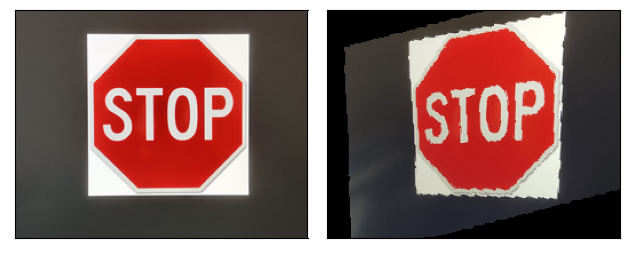

In [12]:
im_new = im[1]
distance = get_distance(im[0], im_new)

im_tmp = im[1]
for i in range(3):
    for j in range(2000):
        im_test = tvt.RandomAffine([-5,5], 
            shear=[-10,10,-10,10], 
            translate=(0.02,0.01), 
            scale=(0.9,1.1)
        )(im_tmp)
        d = get_distance(im_test, im[0])
        if d < distance:
            distance = d
            im_new = im_test
    im_tmp = im_new

print("end with d =", distance.item())
plot([im[0], im_new])
# figure 10

We see from Figure 10 that multiple transformations make image distorted.

A better way is to record parameters and always start from im[1]:

In [160]:
class Parameters(NamedTuple):
    angle:float
    translate: list
    scale: float
    shear: list

    def getvals(self):
        return dict(
            angle=self.angle,
            translate=self.translate,
            scale=self.scale,
            shear=self.shear
        )

    def nextval(self):
        return dict(
            angle=self.angle+random.random()-0.5,
            translate=[x+random.randint(-2,2) for x in self.translate],
            scale=self.scale+(random.random()-0.5)*0.1,
            shear=[x+(random.random()-0.5)*4 for x in self.shear]
        )

distance = get_distance(im[0], im[1])
p = Parameters(10.0, [12,-5], 1.0, [-13.0, 20.0])

end with d = 62.84902572631836
Parameters(angle=13.741787769722185, translate=[11, -5], scale=0.9594661473639455, shear=[-14.7189607526681, 22.99759792365765])


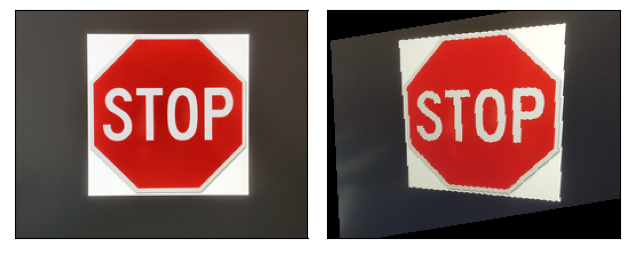

In [167]:
# distance = get_distance(im[0], im[1])
# p = Parameters(10.0, [12,-5], 0.95, [-14.0, 20.0])
for j in range(200000):
    test_p = p.nextval()
    im_test = tvt.functional.affine(im[1], **test_p)
    d = get_distance(im_test, im[0])
    if d < distance:
        distance = d
        p = Parameters(**test_p)

im_new = tvt.functional.affine(im[1], **p.getvals())
print("end with d =", distance.item())
print(p)
plot([im[0], im_new])
# figure 11

Random affine is inefficient since it keeps parallel lines parallel.

## 3.3 Creating Your Own Dataset Class

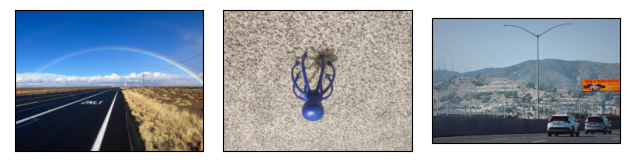

In [127]:
import os
import random

class MyDataset(torch.utils.data.Dataset):
    xform = tvt.Compose([
        tvt.Resize(192, max_size=256),
        tvt.ToTensor(),
        tvt.CenterCrop([192,256]),
        # transform to range [-1, 1]:
        # tvt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])

    def __init__(self, root, transform=xform, label=(lambda x: random.randint(0,10)) ):
        files = os.listdir(root)
        # filter image files:
        files = [f for f in files if os.path.isfile(root+'/'+f) and f.endswith((".jpg",".png"))]
        length = len(files)
        # open file f and apply tvt.Compose(...):
        self.tensors = [transform(Image.open(root+'/'+f)) for f in files]
        self.labels = [label(i) for i in range(length)]


    def __len__(self):
        # return len(self.labels);
        # return 1000 as suggested by piazza:
        return 1000

    def __getitem__(self, index):
        # as suggested by piazza:
        index = index%len(self.labels)
        return (self.tensors[index], self.labels[index])

# show three original photos
# minor issue: the second image is upside down
my_dataset = MyDataset("./photos", 
    transform=tvt.Compose([tvt.Resize(192, max_size=256)])
)
plot([my_dataset[i][0] for i in range(3)])
# figure 12

Photos are augmented below. To keep the same image size I add additional paddings by using `tvt.CenterCrop([192,256])`

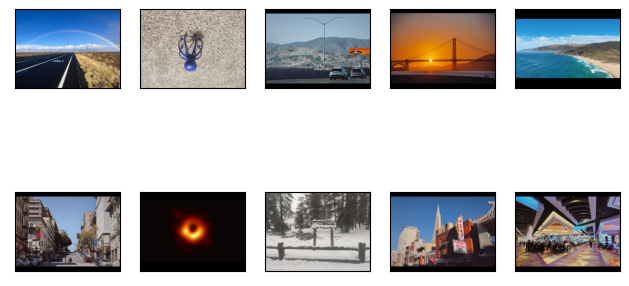

In [108]:
my_dataset = MyDataset("./photos")
dataloader = torch.utils.data.DataLoader(MyDataset("./photos"), batch_size=4, 
    num_workers=2)
plot([[tvt.ToPILImage()(my_dataset[i][0]) for i in range(5)],
    [tvt.ToPILImage()(my_dataset[i][0]) for i in range(5,10)]
])
# figure 13

In [14]:
import time

start = time.time()
for i in range(1000):
    img, label = my_dataset.__getitem__(random.randint(0,9))
end = time.time()
print("using dataset:", end-start)

my_dataloader = iter(dataloader)
start = time.time()
for i in range(250):
    batch = next(my_dataloader)
end = time.time()
print("using dataloader:", end-start)

using dataset: 0.00048232078552246094
using dataloader: 0.23116660118103027


batch size = 4

| workers ->         | 0                    | 1                    | 2                     | 3                    | 4                     | mean   |
|------------------|----------------------|----------------------|-----------------------|----------------------|-----------------------|--------|
| time using dataset (seconds)  | 0.0092475 | 0.0030550 | 0.0021409 | 0.0100965 | 0.0030536 | 0.0032 |
| using dataloader (seconds)| 0.0248429 | 0.2749850 | 0.1713569 | 0.2467529 | 0.2250349 | -      |
|                  |                      |                      |                       |                      |                       |        |

It seems that parallel loader doesn't improve the performance when `batch_size` is 4.